# 1. Pointcloud Visualization

##### Idea

To visualize the given LIDAR pointcloud data we first needed to convert the latitude and longitude information to a cartesian coordinate system that has X, Y and Z values to specify a single point. We can do this by using the latitude and longitude information to calculate the UTM coordinates for each point. As a result we will get a value for the easting (X) and northing (Y). The altitude value, which is already given as meters can thus be seen as the Z value in our new coordinate system. After saving the data to a new file we can then use http://lidarview.com/ to visualize the pointcloud to get a first impression of the data.

##### Problems

Our initial thought was that the intesity of each point in our point cloud is very important to determine the the lane markings in the point cloud. In fact, the lane marking are on a flat surface and the marking itself can also be seen as a flat line on the flat surface. Therfore, we cannot use the shape or variance in the point cloud to detect the lane markings. However, the intensity of each LIDAR point should contain enough information to recover the lane marking from the flat surface since the lane marking should have a higher intensity compared to the plain asphalt or concrete of the street. The problem during the visualization was that the visualization tool that we were using could not visualize the intensity of each point. As you can see in the following image, the visualization uses different colors to denote the elevation instead of the intensity of each point. Although the tool had an option for choosing the intensity the visualization did not work, maybe because the intensity was in a wrong format. Finally, we tried to use this tool https://asmaloney.com/software/ which was able to visualize the intensity in a proper manner. You can now easily recognize the lane markings which shows, that we can use the intensity to identify the lane markings.

##### Results
![Full LIDAR Pointcloud Visualization](FullView.png "Full LIDAR Pointcloud View")

![Intensity LIDAR Pointcloud Visualization](IntensityView.png "Intensity LIDAR Pointcloud View")

###### Code

In [14]:
import numpy as np
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt

from shapely import wkt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

import utm

In [15]:
def read_fuse_to_df(df_name):
    data = []
    
    with open(df_name) as f:  
        line = f.readline()
        while line:
            d = line.split()
            data.append(d)
            line = f.readline()

    a = np.array(data)
    
    pointcloud_df = pd.DataFrame()
    pointcloud_df["Latitude"] = a[:,0]
    pointcloud_df["Longitude"] = a[:,1]
    pointcloud_df["Altitude"] = a[:,2]
    pointcloud_df["Intensity"] = a[:,3]

    return pointcloud_df

In [16]:
def convert_fuse(pointcloud_df, min_x = 0.0, min_y = 0.0, min_z = 0.0):
    pointcloud_df["Latitude"] = pd.to_numeric(pointcloud_df["Latitude"])
    pointcloud_df["Longitude"] = pd.to_numeric(pointcloud_df["Longitude"])
    pointcloud_df["Altitude"] = pd.to_numeric(pointcloud_df["Altitude"])
    pointcloud_df["Intensity"] = pd.to_numeric(pointcloud_df["Intensity"])
    pointcloud_df["Easting"] = pointcloud_df.apply(lambda x: utm.from_latlon(x["Latitude"], x["Longitude"])[0], axis = 1)
    pointcloud_df["Northing"] = pointcloud_df.apply(lambda x: utm.from_latlon(x["Latitude"], x["Longitude"])[1], axis = 1)
    
    if min_x == 0:
        min_x = pointcloud_df["Easting"].min()
    if min_y == 0:
        min_y = pointcloud_df["Northing"].min()   
    if min_z == 0:
        min_z = pointcloud_df["Altitude"].min()    
        
    utm_coords = utm.from_latlon(pointcloud_df.loc[0,"Latitude"], pointcloud_df.loc[0,"Longitude"])

    zone_number = utm_coords[2]
    zone_letter = utm_coords[3]
        
    pointcloud_df["Easting"] = pointcloud_df["Easting"] - min_x    
    pointcloud_df["Northing"] = pointcloud_df["Northing"] - min_y
    pointcloud_df["Altitude"] = pointcloud_df["Altitude"] - min_z
    
    return pointcloud_df, (min_x, min_y, min_z), (zone_number, zone_letter)

In [17]:
pointcloud_df = read_fuse_to_df('./data/pointcloud.fuse')
pointcloud_df, (min_x, min_y, min_z), (number, letter) = convert_fuse(pointcloud_df)

pointcloud_df.head()

,Latitude,Longitude,Altitude,Intensity,Easting,Northing
0,45.903883,11.028414,10.6604,10,108.226321,65.043547
1,45.903683,11.028221,12.6662,5,93.822923,42.445590
2,45.903683,11.028222,12.6415,7,93.938542,42.355143
3,45.903682,11.028224,12.6263,7,94.080686,42.289830
4,45.903681,11.028226,12.6188,7,94.233803,42.220349


In [18]:
xyzi_df = pointcloud_df[["Easting", "Northing", "Altitude", "Intensity"]]
xyzi_df.to_csv("./data/pointcloud.xyz", sep=" ", header=False, index=False)
xyzi_df.head()

,Easting,Northing,Altitude,Intensity
0,108.226321,65.043547,10.6604,10
1,93.822923,42.445590,12.6662,5
2,93.938542,42.355143,12.6415,7
3,94.080686,42.289830,12.6263,7
4,94.233803,42.220349,12.6188,7


# 2. Pointcloud Filtering

##### Idea
To identify the lanes in a much better way we first tried to remove all the noise from the data. In our case that means that we wanted to remove points with an intensity that is too high or too low to be a candidate lane marking point. Since different light conditions throughout the day might influence the intensity value, we first calculated the mean and standard deviation intensity for all points. The assumption here is that the lane marking points have a higher intensity value compared to the mean of all pointcloud points. We could have also set an adaptive threshold per pointcloud slice. However, since there was no slice information left we had to use this approach. The nefit of an adaptive threshold would have been that this approach is more robust against different light conditions within the current scene (e.g. a car that is just about to enter a tunnel but has not entered the tunnel yet). The first figure in the results section below shows the lane marking cloud point after the first filtering process.

As you can also see in the figure, there are a lot of points off the road that obviosly do not belong to the lanes. To reduce the number of points that are off the road we used the actual trajectory information in order to remove points that are too far away from the actual trajectory line. We use a threshold of 20 meters to remove all points that are further away. That way we can reduce the number of points from 32191 to 18496. The second figure in the results below shows the remaining points after filtering based on the trajectory lines.

##### Problems
One major problem was that we could not use an adaptive threshold to remove more noise. While we could have computed an adaptive threshold in the 3 dimensional space, this approach would have been too computationaly expensive especially for the large dataset that we had in the beginning. A problem that might occur with our current algorithm setup are the boundaries for our threshold. Right now we tried to tweek the threshold boundaries to get good results. It would be good to test our current thresholds on larger datasets to see if our approach is valid or if we really need to use an adaptive threshold.

##### Results
![First LIDAR Pointcloud Filter](FirstFilter.png "First LIDAR Pointcloud Filter")
![Trajectory LIDAR Pointcloud Filter](TrajectoryFilter.png "Trajectory LIDAR Pointcloud Filter")

##### Code

In [39]:
def convert_to_shape(row):
    return wkt.loads("POINT (" + str(row["Easting"]) + " " + str(row["Northing"]) +" " + str(row["Altitude"]) + ")")

In [104]:
def filter_by_mean_value(pointcloud_df, left_bound, right_bound):

    mean = pointcloud_df["Intensity"].mean()
    std = pointcloud_df["Intensity"].std()

    lanes_df = pointcloud_df[pointcloud_df["Intensity"] > mean + left_bound * std]
    lanes_df = lanes_df[lanes_df["Intensity"] < mean + right_bound * std ]

    print("MEAN FILTER:")
    print("============")
    print("Intensity - Mean value:      ", mean)
    print("Intensity - Std value:       ", std)
    print("Intensity - Lower bound:     ", mean + 1 * std)
    print("Intensity - Upper bound:     ", mean + 7 * std)
    print("Intensity - Filtered points: ", len(lanes_df))
    print("Intensity - Original points: ", len(pointcloud_df))
    print("Intensity - Reduction to %:  ", len(lanes_df)/len(pointcloud_df))
    
    return lanes_df

In [105]:
def get_trajectory_line(trajectory_file='./data/trajectory.fuse', min_x=0.0, min_y=0.0, min_z=0.0):
    trajectory_df = read_fuse_to_df(trajectory_file)
    trajectory_df, (min_x, min_y, min_z), (number, letter) = convert_fuse(trajectory_df, min_x, min_y, min_z)
    trajectory_df[["Easting", "Northing", "Altitude", "Intensity"]].to_csv("./data/trajectory.xyz", index=False)
    print(trajectory_df[["Easting", "Northing", "Altitude", "Intensity"]])

    line = "LINESTRING("
    for index, row in trajectory_df.iterrows():
        line = line + str(row["Easting"]) + " " + str(row["Northing"]) + " " + str(row["Altitude"]) + ", "
    line = line[:-2] + ")"
    trajectory_line = wkt.loads(line)
    
    return trajectory_line, (min_x, min_y, min_z), (number, letter)

In [109]:
def filter_by_trajectory_line(pointcloud_df, trajectory_line):
    rows = []

    for index, row in pointcloud_df.iterrows():
        distance = trajectory_line.distance(row["Shape"])
        if distance <= 20:
            rows.append(row)

    filtered_lanes_df = pd.DataFrame(rows, columns=['Easting', 'Northing', 'Altitude', 'Intensity', 'Shape'])
    
    print("\nTRAJECTORY FILTER:")
    print("============")
    print("Intensity - Filtered points: ", len(filtered_lanes_df))
    print("Intensity - Original points: ", len(pointcloud_df))
    print("Intensity - Reduction to %:  ", len(filtered_lanes_df)/len(pointcloud_df))
    return filtered_lanes_df

In [110]:
trajectory_line, (min_x, min_y, min_z), (number, letter) = get_trajectory_line('./data/trajectory.fuse',min_x, min_y, min_z)

lanes_df = xyzi_df.copy()
lanes_df = filter_by_mean_value(lanes_df, 1, 7)
lanes_df[['Easting', 'Northing', 'Altitude', 'Intensity']].to_csv("./data/filter_mean.xyz", index=False)
lanes_df['Shape'] = lanes_df.apply(convert_to_shape, axis=1)
lanes_df = filter_by_trajectory_line(lanes_df, trajectory_line)
lanes_df[['Easting', 'Northing', 'Altitude', 'Intensity']].to_csv("./data/filter_trajectory.xyz", index=False)

      Easting    Northing  Altitude  Intensity
0   80.666066   33.179204    5.7431        255
1   86.068856   44.074984    5.7281        255
2   89.930128   51.890935    5.7252        255
3   93.998028   60.187973    5.7307        255
4   99.339125   71.096650    5.7376        255
5  105.254758   83.187282    5.7454        255
6  110.617644   94.092080    5.7775        255
7  114.134203  101.207774    5.7856        255
8  119.562210  112.114238    5.8083        255
MEAN FILTER:
Intensity - Mean value:       8.246153096095984
Intensity - Std value:        10.862899760737132
Intensity - Lower bound:      19.109052856833117
Intensity - Upper bound:      84.2864514212559
Intensity - Filtered points:  32191
Intensity - Original points:  430736
Intensity - Reduction to %:   0.07473487240444263

TRAJECTORY FILTER:
Intensity - Filtered points:  18496
Intensity - Original points:  32191
Intensity - Reduction to %:   0.5745705321363114


# 3. Lane Marking Detection

##### Idea
After filtering the pointcloud with our trajectory filter and the mean value filter we can already see the lane markings. Unfortunately, we can also see the lane markings of the road into the other direction. However, you can seem that there are less points for these lane markings. Obviosly the density of points in a small area can be used to identify larger structures such as lane markings. Therefore, we wanted to group points that might belong together. We did this by using a Scikit Learn clustering algorithm. The DBSCAN algorithm allows us to specify a number for the points that are required to form a cluster and the distance between clusters. In our case this means that we require 40 points to build a cluster and the distance to be counted towards a cluster is 0.05. The result of the clustering algorithm can be seen in the following figure. Another side effect of the clustering is that we can get rid of 
4073 more points so that we now only have 14423 points that are most likely to be part of a lane marking.

After clustering the points we can already see the lines. To gather actual line segments from the data we took the two points within each cluster that are furthest apart from each other. These two points serve as the starting and end point for a line segment. We use efficient numpy and scipy methods to calculate the distances in a quick manner. The result of the calculation can be visualized using matplotlib. The rendered example is illustrated by figure 2 in the results section below. The last step is then fusing some of the line segments that are quite close together. This allows us to increase the line length of some segments. This step is visualized in the third figure in the results section below.

##### Problems
An overall problem at this step ws aligning the line segments to the road trajectory. Since we do not know if the current road segment is very curvy or just straight we cannot assume that the road is straight all the time. However, our current algorithm assumes that the LIDAR pointcloud only represents a short segment 20 - 30 meters so that we might be able to solve this problem. Another problem is that some of the line segments are not straight or completely parallel to the trajectory. We plan to correct these issues by aligning all segments to the trajectory which should also allow us to handle curvatures.

##### Results
![Clustering LIDAR Pointcloud](Clustering.png "Clustering LIDAR Pointcloud")

![Lines LIDAR Pointcloud](Lines.png "Lines LIDAR Pointcloud")

![Fused LIDAR Pointcloud Lines](Fused.png "Fused LIDAR Pointcloud Lines")

##### Code

In [111]:
X = lanes_df[["Easting", "Northing", "Altitude"]].values
X = StandardScaler().fit_transform(X)

db = DBSCAN(eps=0.06, min_samples=30).fit(X)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

lanes_df["Group"] = labels
cluster_df = lanes_df[["Easting", "Northing", "Altitude", "Group"]]
cluster_df = cluster_df[cluster_df["Group"]>=0]
cluster_df.to_csv("./data/clustering.xyz",index=False)
cluster_df.head()

,Easting,Northing,Altitude,Group
369,92.874609,37.312992,3.0119,0
399,92.455209,36.957684,3.0039,0
496,92.065702,36.098402,3.0221,0
500,92.023889,36.063986,3.0189,0
916,91.028105,33.621722,3.0236,1


In [112]:
print("Final list of labels:       ", labels)
print("Number of Clusters:         ", n_clusters_)
print("Number of Noise points:     ", n_noise_)
print("Number of clustered points: ", len(cluster_df))

Final list of labels:        [-1 -1 -1 ...  4  5  4]
Number of Clusters:          24
Number of Noise points:      3435
Number of clustered points:  15061


In [113]:
lines = []

for cluster in range(n_clusters_):
    sub_cluster_df = cluster_df[cluster_df["Group"] == cluster]
    points = sub_cluster_df[["Easting","Northing", "Altitude"]].values
    distances = squareform(pdist(points))
    for i in range(0,15):
        max_index = np.argmax(distances)
        i1, i2 = np.unravel_index(max_index, distances.shape)
        distances[i1,i2] = 0.0
    max_dist = np.max(distances)
    max_index = np.argmax(distances)
    i1, i2 = np.unravel_index(max_index, distances.shape)
    p1 = sub_cluster_df.iloc[i1]
    p2 = sub_cluster_df.iloc[i2]
    lines.append(([p1["Easting"], p2["Easting"]],[p1["Northing"], p2["Northing"]], [p1["Altitude"], p2["Altitude"]]))

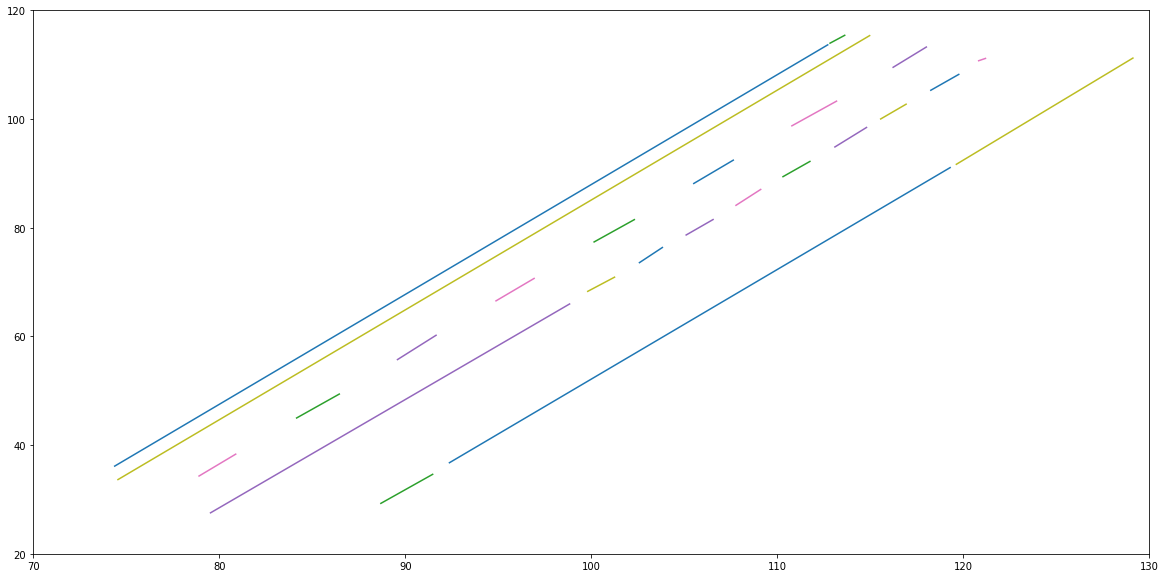

Number of prototype lane markings:  24


In [115]:
plt.figure(figsize=(20,10))
plt.xlim(70, 130), plt.ylim(20,120)

for l in lines:
    plt.plot(l[0], l[1], l[2])
    
plt.show()

print("Number of prototype lane markings: ", len(lines))

In [116]:
def create_line(coords):
    return wkt.loads("LINESTRING(" + str(coords[0][0]) + " " +str(coords[1][0]) + ", " + str(coords[0][1]) + " " + str(coords[1][1]) +")")
    
distance_matrix = []

for l1 in range(len(lines)):
    prototype = []
    distances = []
    line1 = create_line(lines[l1])
    for l2 in range(len(lines)):
        line2 = create_line(lines[l2])
        d = line1.distance(line2)
        if d == 0:
            d = 100
        distances.append(d)
        
    distance_matrix.append(distances)

distances = np.array(distance_matrix)

In [117]:
fusions = set()

for row in range(distances.shape[0]):
    for column in range(distances.shape[1]):
        value = distances[row,column]
        if value < 1.0:
            min_index = min(row, column)
            max_index = max(row, column)
            fusions.add((min_index, max_index))
            
fusions = list(fusions)
fusion_clusters = []
finished = []
fusions.sort()

for i in range(len(fusions)):
    new_cluster = list(fusions[i])
    if new_cluster[0] not in finished and new_cluster[1] not in finished:
        for j in range(i+1, len(fusions)):
            f = list(fusions[j])
            if (f[0] in new_cluster or f[1] in new_cluster) and f[0] not in finished:
                new_cluster.extend(f)
        fusion_clusters.append(list(set(new_cluster)))
        finished.extend(list(set(new_cluster)))
        
fused_lines = [item for sublist in fusion_clusters for item in sublist]
for i in range(distances.shape[0]):
    if i not in fused_lines:
        fusion_clusters.append([i])

In [118]:
final_lane_markings = []

for cluster in fusion_clusters:
    if len(cluster) == 1:
        final_lane_markings.append(lines[cluster[0]])
    else:
        points = []
        for segment in cluster:
            l = lines[segment]
            points.append([l[0][0], l[1][0], l[2][0]])
            points.append([l[0][1], l[1][1], l[2][1]])
        points = np.array(points)
        distances = squareform(pdist(points))
        max_dist = np.max(distances)
        max_index = np.argmax(distances)
        i1, i2 = np.unravel_index(max_index, distances.shape)
        
        p1 = points[i1]
        p2 = points[i2]

        final_lane_markings.append(([p1[0], p2[0]],[p1[1], p2[1]], [p1[2], p2[2]]))

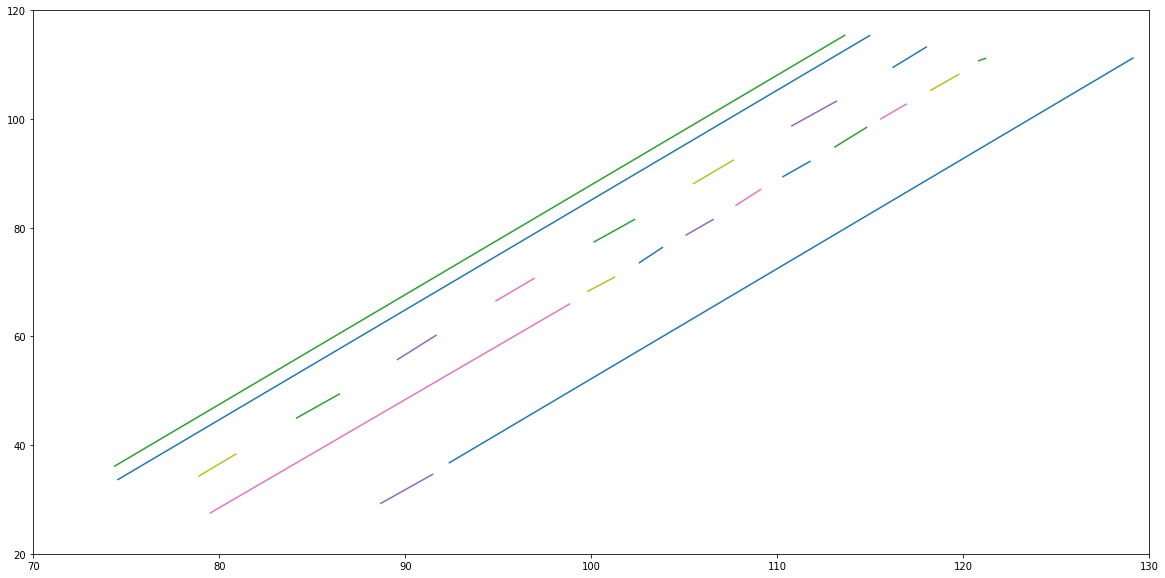

Number of final lane markings:  22


In [119]:
plt.figure(figsize=(20,10))
plt.xlim(70, 130), plt.ylim(20,120)

for l in final_lane_markings:
    plt.plot(l[0], l[1], l[2])
    
plt.show()

print("Number of final lane markings: ", len(final_lane_markings))

# 4. Correction and Output

##### Idea

For the output the only thing that we needed to do is convert the UTM coordinates back to the latitude and longitude format. In the beginning we also shifted all the coordinates closer to the center of the coordinate system which means that we first have to shift all the UTM coordinates back to their original/true location. By using the python utm package we can easily transform the coordinates back into the original format. We then save the final output in a csv file. Each row contains a start and an end location for a line segment. That means that we will have a total of 22 rows + column headers.

##### Results

![Output CSV Final Lane Detections](Output.png "Output CSV Final Lane Detections")

##### Code

In [ ]:
output_rows = []

for line in final_lane_markings:
    start_x = line[0][0] + min_x
    start_y = line[1][0] + min_y
    start_z = line[2][0] + min_z
    end_x = line[0][1] + min_x
    end_y = line[1][1] + min_y
    end_z = line[2][1] + min_z
    (start_latitude, start_longitude) = utm.to_latlon(start_x,start_y,number, letter)
    (end_latitude, end_longitude) = utm.to_latlon(end_x,end_y,number, letter)
    output_rows.append([start_latitude, start_longitude, start_z, end_latitude, end_longitude, end_z])
    
output = pd.DataFrame(output_rows, columns=["Start_Latitude", "Start_Longitude", "Start_Z","End_Latitude", "End_Longitude", "End_Z"])
output.to_csv("./data/output.csv", header=True, index=False)